In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score as sc
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import pyspark
from pyspark.sql import functions as F, SparkSession, DataFrame
from pyspark.sql.functions import concat_ws, col
from pyspark.ml.fpm import FPGrowth

## Load Dataset

In [2]:
transaction = pd.read_csv('\transactions_train.csv')
articles = pd.read_csv('\articles.csv')
customers = pd.read_csv('\customers.csv')

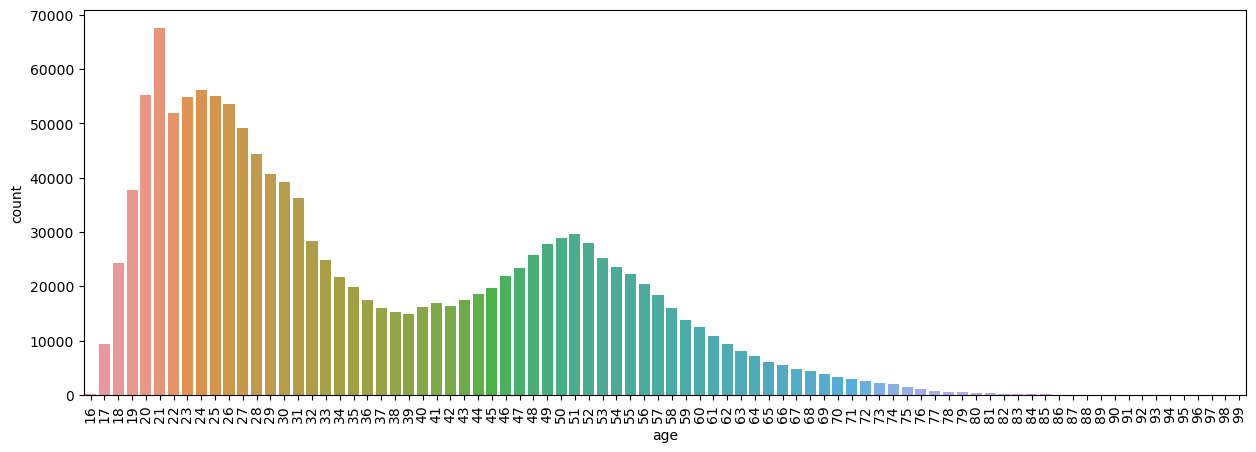

In [205]:
ages = pd.DataFrame(customers['age'].copy().value_counts()).reset_index()
ages.columns = ['age', 'count']
ages['age'] = ages['age'].astype(int)
plt.figure(figsize=(15,5))
sns.barplot(x=ages['age'], y=ages['count'])
plt.xticks(rotation=90)
plt.show()

# Data Preparation

### Data Cleaning

In [3]:
for col in list(articles.select_dtypes(include='object').columns):
    print(col,':',articles[col].str.contains('Unknown').sum())
articles = articles.replace('Unknown', np.nan)

prod_name : 0
product_type_name : 121
product_group_name : 121
graphical_appearance_name : 52
colour_group_name : 28
perceived_colour_value_name : 28
perceived_colour_master_name : 685
department_name : 0
index_code : 0
index_name : 0
index_group_name : 0
section_name : 0
garment_group_name : 3873
detail_desc : 0


In [4]:
#Change t_date and article_id types
transaction['t_dat'] = pd.to_datetime(transaction['t_dat'])
transaction['article_id'] = transaction['article_id'].astype(object)

Duplicated rows means the customer bought the same product. Create a column which shows the number of item bought by customers in each transaction.

In [5]:
df = transaction.groupby(transaction.columns.tolist()).size().reset_index().rename(columns={0:'qty'})
#Create a new column containing invoice number based on t_dat and customer_id
df.insert(loc=0, column='invoice_no', value=df.set_index(['t_dat','customer_id']).index.factorize()[0]+1)
#Add 100000000 to invoice no
df['invoice_no'] = df['invoice_no']+100000000
#Create total_price column by multiplying price with quantity
df['total_price'] = df['price']*df['qty']
#Use only transaction with article_id are still in articles dataframe
df = df[df['article_id'].isin(articles['article_id'])].reset_index(drop=True)

## Filter transactions based on postal code

In [13]:
#Merge df and postal_code column from customer dataframe
df_merge = pd.merge(df, customers[['postal_code','customer_id']], on='customer_id', how='left')
#Sort postal code based on the number of unique transactions from high to low.
postal_rank = df_merge.groupby('postal_code').agg(transaction=('invoice_no','nunique')).sort_values('transaction',ascending=False)
postal_rank.head(2)

,transaction
postal_code,
2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c,199523
1f5bd429acc88fbbf24de844a59e438704aa8761bc7b99fd977cad297c50b74c,1439


In [5]:
#Create a list of top 5 postal code by total transactions
pop_postal = list(postal_rank.head(2).index)
#Filter df_merge based on the pop_postal list
df_new = df_merge[df_merge['postal_code'].isin(pop_postal)].reset_index(drop=True)

## Data Preprocessing

In [109]:
df_product_name = pd.merge(df_new,articles[['prod_name','product_type_name','product_code',
                                            'colour_group_name','product_type_no','article_id']],
                           on='article_id', how='left')

#Fill missing values in product_type_name
name_type = df_product_name[df_product_name['product_type_name'].notnull()].drop_duplicates(subset='product_code')
name_type = name_type.set_index('product_code')['product_type_name']
df_product_name['product_type_name'] = df_product_name['product_type_name'].fillna(
                                                    df_product_name['product_code'].map(name_type))

## Data Preprocessing for Clustering

In [222]:
def prep_cluster(df):
    #Convert t_date type to datetime
    df_product_name['t_dat'] = pd.to_datetime(df_product_name['t_dat'])
    #Extract month from t_dat and assign it to month column
    df_product_name['month'] = df_product_name['t_dat'].dt.month
    #Create a dataframe of the total quantity based on product type and month
    df_month = df_product_name.groupby(['month','product_type_name']).agg(count=('qty','sum'))
    #Move product type position to column and replace missing values with 0
    df_month = df_month.unstack().fillna(0).droplevel(0, axis=1).reset_index()
    indeks = df_month.index
    cols = df_month.columns
    
    #Scaling
    df_month2 = df_month.copy().set_index('month')
    cols = df_month2.columns
    minmax = MinMaxScaler()
    df_scaled = minmax.fit_transform(df_month2)
    df_scaled = pd.DataFrame(df_scaled.transpose(), columns=range(1,13))
    df_scaled.index = cols
    return df_scaled

scaled = prep_cluster(df_product_name)

In [226]:
scaled[scaled>=0.5]=1
scaled[scaled<0.5]=0

<AxesSubplot:ylabel='product_type_name'>

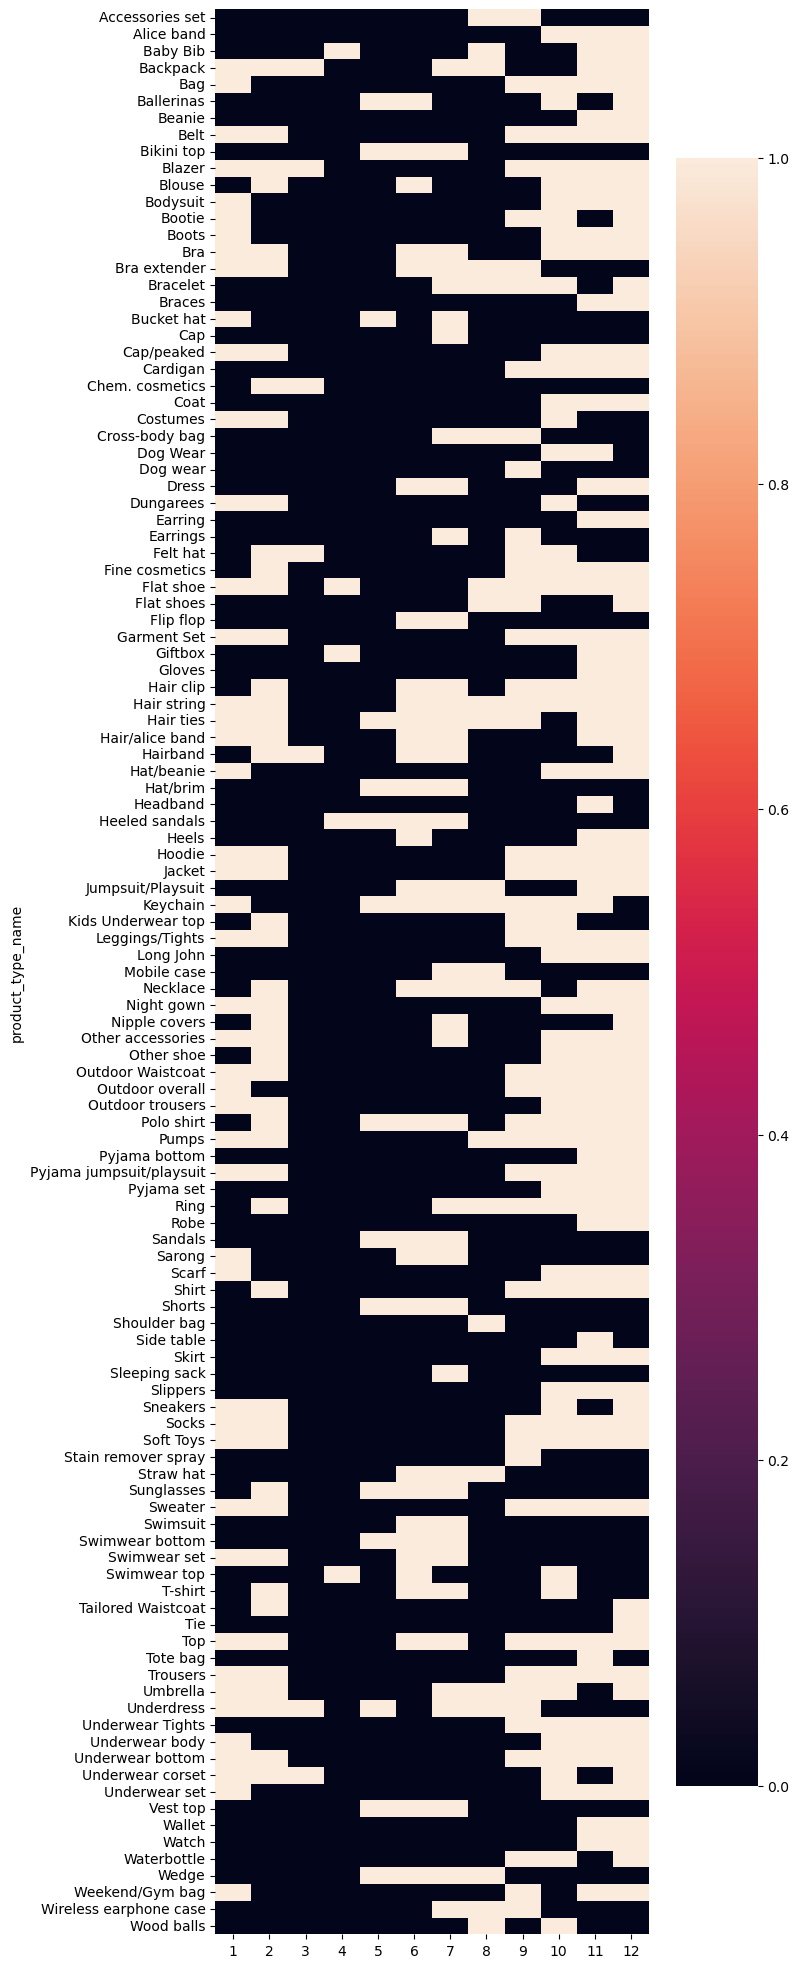

In [227]:
plt.figure(figsize=(7,25))
sns.heatmap(scaled)

# Modeling

In [138]:
km_sil = []
for i in range(2,12):
    ts = TimeSeriesKMeans(n_clusters=i,random_state=100).fit(scaled)
    preds = ts.predict(scaled)
    score = silhouette_score(scaled, preds)
    print('n_clusters=',i,'| Silhouette score=', score)
    km_sil.append(score)

C:\Users\Filzahanti\AppData\Roaming\Python\Python39\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 115 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


n_clusters= 2 | Silhouette score= 0.36904049005608197


C:\Users\Filzahanti\AppData\Roaming\Python\Python39\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 115 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


n_clusters= 3 | Silhouette score= 0.1631020568824158


C:\Users\Filzahanti\AppData\Roaming\Python\Python39\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 115 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


n_clusters= 4 | Silhouette score= 0.16657049290161827


C:\Users\Filzahanti\AppData\Roaming\Python\Python39\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 115 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


n_clusters= 5 | Silhouette score= 0.12254449088565567


C:\Users\Filzahanti\AppData\Roaming\Python\Python39\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 115 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


n_clusters= 6 | Silhouette score= 0.08291128487602738


C:\Users\Filzahanti\AppData\Roaming\Python\Python39\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 115 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


n_clusters= 7 | Silhouette score= 0.05881929603260697


C:\Users\Filzahanti\AppData\Roaming\Python\Python39\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 115 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


n_clusters= 8 | Silhouette score= 0.049739693819001694


C:\Users\Filzahanti\AppData\Roaming\Python\Python39\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 115 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


n_clusters= 9 | Silhouette score= 0.025776568308686708


C:\Users\Filzahanti\AppData\Roaming\Python\Python39\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 115 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


n_clusters= 10 | Silhouette score= 0.04954283524037356


C:\Users\Filzahanti\AppData\Roaming\Python\Python39\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 115 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


n_clusters= 11 | Silhouette score= 0.0560576106051599


In [139]:
def cluster(df, n_cluster):
    ts = TimeSeriesKMeans(n_clusters=n_cluster,random_state=100).fit(df)
    pred = ts.predict(df)
    #predicted
    df_ts = scaled.copy()
    df_ts['clust'] = pred
    df_ts.columns = df_ts.columns.astype(str)
    return df_ts

result = cluster(scaled, 2)

C:\Users\Filzahanti\AppData\Roaming\Python\Python39\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 115 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [ ]:
result[result>=0.5]=1
result[result<0.5]=0

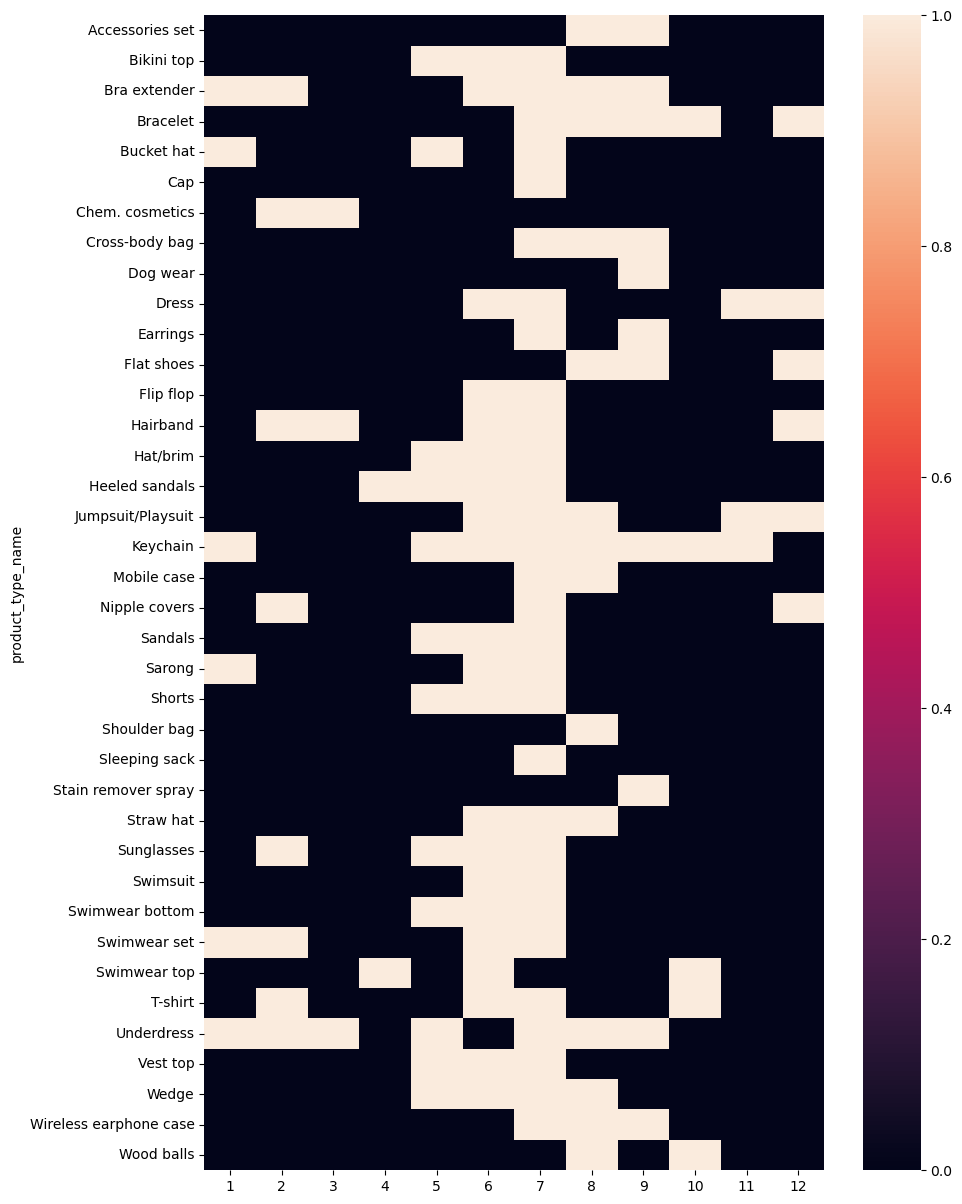

In [230]:
plt.figure(figsize=(10,15))
sns.heatmap(result[result['clust']==0].drop(['clust'], axis=1))
plt.show()

After clustering the month based on products sales, split the transaction into March-August and September-February

# Data Preparation for Market Basket Analysis

In [5]:
df_new = pd.read_csv('D:\FILZA 1\dibimbing\dataset\h&m\df_2_postal_code.csv')
#Merge df_new and product_code column based on article_id
df_merge_product = pd.merge(df_new, articles[['product_code','colour_group_name','product_type_name','prod_name',
                                              'product_type_no','article_id']], on='article_id', how='left')

#Convert t_date type to datetime
df_merge_product['t_dat'] = pd.to_datetime(df_merge_product['t_dat'])
#Extract month and year from t_dat and assign it to month column
df_merge_product['month'] = df_merge_product['t_dat'].dt.to_period('M')

In [ ]:
#product name and price dataframe
df_price_prod = df_merge_product[['prod_name','price']].copy().groupby('prod_name')['price'].nsmallest(1)
df_price = pd.DataFrame(df_price_prod).reset_index().drop('level_1', axis=1)

#invoice no and total price dataframe
df_price_inv = df_merge_product[['invoice_no','total_price']].copy().groupby('invoice_no')['total_price'].sum()
inv_price = pd.DataFrame(df_price_inv).reset_index()
inv_price['invoice_no'] = inv_price['invoice_no'].astype(str)

In [8]:
#for rules
rules6 = df_merge_product[(df_merge_product['month']>='2020-3')&(df_merge_product['month']<='2020-5')]
df_5 = df_merge_product[df_merge_product['month']=='2020-5']
#for prediction
df_6 = df_merge_product[df_merge_product['month']=='2020-6']

In [9]:
def prep_basket(df):
    #Combine product_code into a list based on invoice_no
    df_basket = pd.DataFrame(df.groupby('invoice_no').prod_name.apply(list)).reset_index()
    #Remove duplicates from list
    df_basket['prod_name'] = df_basket['prod_name'].apply(lambda x: list(set(x)))
    #Convert invoice_no to string
    df_basket['invoice_no'] = df_basket['invoice_no'].astype(str)
    #Convert product_code column to list of strings
    product_list = list(df_basket.prod_name)
    return df_basket
    
df_basket6 = prep_basket(df_6)
df_basket5 = prep_basket(df_5)
df_rules6 = prep_basket(rules6)

# Market Basket Analysis with FP-Growth

In [11]:
def next_prediction(product,rules):
    for j in product: 
            if len(rules[rules['antecedent']=={j}].values) != 0:
                prediction = list(rules[rules['antecedent']=={j}]['consequent'].values[0])[0]
                
                if prediction not in product:
                    lift = rules[rules['antecedent']=={j}]['lift'].values[0] 
                    return(prediction, lift)
    return(0, 0)

def product_prediction(basket, rules):
    preds = []
    lifts = []
    
    for i in range(basket.shape[0]):
        list_product = set(basket['prod_name'][i])
        if len(rules[rules['antecedent']==list_product].values) != 0:
            prediction = list(rules[rules['antecedent']==list_product]['consequent'].values[0])[0]
            lift = rules[rules['antecedent']==list_product]['lift'].values[0]
            preds.append(prediction)
            lifts.append(lift)

        elif len(rules[rules['antecedent']==list_product].values) == 0:
            prediction, lift = next_prediction(basket['prod_name'][i], rules)
            preds.append(prediction)
            lifts.append(lift)
            
    return(preds, lifts)


def prep_rules(df):
    df = df.sort_values(by='lift', ascending=False).reset_index(drop=True)
    df['antecedent'] = df['antecedent'].apply(lambda x: set(x))
    df['consequent'] = df['consequent'].apply(lambda x: set(x))
    return df

def get_avg_df(df, rules):
    predictions, lifts = product_prediction(df, rules)
    df['prediction'] = predictions
    df['lift'] = lifts
    avg_predict = df['lift'].mean()
    return avg_predict, df

In [12]:
spark = SparkSession.builder.appName('spark basket').getOrCreate()
spark.conf.set('spark.sql.execution.arrow.enabled','true')

### June (Data from March-May 2020)

In [17]:
'''Rules for month 6'''
#Convert df_basket to PySpark dataframe
spark_6 = spark.createDataFrame(df_rules6)
fpgrowth6 = FPGrowth(itemsCol='prod_name', minSupport=0.0005, minConfidence=0.1)
model = fpgrowth6.fit(spark_6)
items_freq = model.freqItemsets
rules6 = model.associationRules
rules6.show()

+--------------------+--------------------+-------------------+------------------+--------------------+
|          antecedent|          consequent|         confidence|              lift|             support|
+--------------------+--------------------+-------------------+------------------+--------------------+
|      [1p Fun Socks]|          [1p Socks]| 0.6904761904761905| 228.7777777777778|0.002431254191817572|
|      [1p Fun Socks]|    [1p Short Socks]|0.21428571428571427|106.49999999999999|7.545271629778672E-4|
|       [Gyda blouse]|    [Paulina blouse]|0.10843373493975904|  25.3607370659107|7.545271629778672E-4|
|[Baby Love Cheeky...|[Baby Love Triang...| 0.7272727272727273|1084.3636363636365|6.706908115358819E-4|
|         [Alpha top]|[Alpha essential ...|0.14285714285714285|46.054054054054056|7.545271629778672E-4|
|         [Alpha top]|       [Charlie Top]|0.14285714285714285|12.347826086956522|7.545271629778672E-4|
|  [Sporty spice top]|[Sporty Spice Hig...|               0.36| 

In [18]:
rules_6 = rules6.select('*').toPandas()
rules_6 = prep_rules(rules_6)
avg, df_basket6 = get_avg_df(df_basket6, rules_6)
print(avg)

18.573543216700966


In [20]:
rules_6

,antecedent,consequent,confidence,lift,support
0,{Baby Love Cheeky Brief},{Baby Love Triangle Top},0.727273,1084.363636,0.000671
1,{Baby Love Triangle Top},{Baby Love Cheeky Brief},1.000000,1084.363636,0.000671
2,{Ginger Top},{Ginger Highwaist},0.545455,813.272727,0.000503
3,{Ginger Highwaist},{Ginger Top},0.750000,813.272727,0.000503
4,{Ursula Cheeky V Brief},{Ursula Top},0.571429,757.333333,0.000671
...,...,...,...,...,...
210,{Pluto RW slacks (1)},{Primo slacks},0.101266,8.506329,0.001341
211,{Primo slacks},{Pluto RW slacks (1)},0.112676,8.506329,0.001341
212,{Shake it in Balconette},{Simple as that Cheeky Tanga},0.100000,8.400000,0.000587
213,{Timeless Cheeky Brief},{Simple as That Triangle Top},0.107527,8.066545,0.000838


In [19]:
merge6 = pd.merge(df_basket6, df_price, left_on='prediction', right_on='prod_name', how='left').fillna(0)
merge6 = pd.merge(merge6, inv_price, on='invoice_no', how='left').fillna(0)
merge6['price_est'] = merge6['price']*merge6['lift']*0.01
print('revenue generation:', merge6['price_est'].sum())
print('revenue :', merge6['total_price'].sum())
print(100*merge6['price_est'].sum()/merge6['total_price'].sum())

revenue generation: 16.562371785371937
revenue : 654.2266440677952
2.531595424238888


In [22]:
merge6.sample(5)

,invoice_no,prod_name_x,prediction,lift,prod_name_y,price,total_price,price_est
8376,107993163,"[Susan tank dress, Eleonor button dress]",0,0.000000,0,0.000000,0.053356,0.00000
7196,107931720,[Shake it in Balconette],Swish HR wide side Brief,32.237838,Swish HR wide side Brief,0.006763,0.025407,0.00218
3316,107715147,"[PIXI PINNAFORE, Price TEE TVP]",Money tee TVP,28.673077,Money tee TVP,0.004220,0.014373,0.00121
8278,107987321,[Gemini skirt.],0,0.000000,0,0.000000,0.020322,0.00000
3789,107736191,"[Mademoiselle dress, Chiba Dress, Dragonfly dr...",0,0.000000,0,0.000000,0.067339,0.00000


### June (Data from May 2020)

In [49]:
'''Rules for month 6'''
#Convert df_basket to PySpark dataframe
spark_6 = spark.createDataFrame(df_basket5)
fpgrowth = FPGrowth(itemsCol='prod_name', minSupport=0.0005, minConfidence=0.15)
model = fpgrowth.fit(spark_6)
items_freq = model.freqItemsets
rules6 = model.associationRules
rules6.show()

+--------------------+--------------------+-------------------+------------------+--------------------+
|          antecedent|          consequent|         confidence|              lift|             support|
+--------------------+--------------------+-------------------+------------------+--------------------+
|      [1p Shaftless]|      [1p Fun Socks]| 0.2727272727272727| 82.15151515151514|5.533013648100332E-4|
|    [CS Paula dress]|[Pluto RW slacks ...| 0.3333333333333333|24.097777777777775|7.377351530800443E-4|
|      [1p Fun Socks]|      [1p Shaftless]|0.16666666666666666| 82.15151515151514|5.533013648100332E-4|
|      [1p Fun Socks]|  [1p Pattern Socks]|0.16666666666666666|225.91666666666666|5.533013648100332E-4|
|      [1p Fun Socks]|          [1p Socks]|                0.5|208.53846153846155|0.001659904094430...|
|[Chubba Chubb Hig...|[Timeless Padded ...|0.45454545454545453| 84.98432601880877|9.221689413500553E-4|
|[Chubba Chubb Hig...|        [Ginger Top]| 0.2727272727272727|1

In [42]:
rules_6 = rules6.select('*').toPandas()
rules_6 = prep_rules(rules_6)
avg, df_basket6 = get_avg_df(df_basket6, rules_6)
print(avg)

28.752439401111843


In [43]:
rules_6

,antecedent,consequent,confidence,lift,support
0,{Tropicana Brazilian CON},{Tropicana Top},1.000000,1355.500000,0.000553
1,{Tropicana Top},{Tropicana Brazilian CON},0.750000,1355.500000,0.000553
2,{Tropic Like Its Hot Brief},{Tropic Like Its Hot Top},1.000000,1084.400000,0.000553
3,{Tropic Like Its Hot Top},{Tropic Like Its Hot Brief},0.600000,1084.400000,0.000553
4,{Bondi Rescue Tie Brief},{Bondi Rescue Bandeau},0.600000,1084.400000,0.000553
...,...,...,...,...,...
482,"{Surfs Up Tanga, Surfs Up Push Triangle}",{Simple as That Triangle Top},0.173913,8.344748,0.000738
483,{Lazer Razer Triangle Top},{Simple as that Cheeky Tanga},0.157895,8.311702,0.000553
484,{Amalia dress},{Tilly (1)},0.150000,8.052475,0.000553
485,{Lazer Razer Triangle Top},{Simple as That Triangle Top},0.157895,7.576153,0.000553


In [44]:
merge6 = pd.merge(df_basket6, df_price, left_on='prediction', right_on='prod_name', how='left').fillna(0)
merge6 = pd.merge(merge6, inv_price, on='invoice_no', how='left').fillna(0)
merge6['price_est'] = merge6['price']*merge6['lift']*0.01
print('revenue generation:', merge6['price_est'].sum())
print('revenue :', merge6['total_price'].sum())
print(100*merge6['price_est'].sum()/merge6['total_price'].sum())

revenue generation: 24.777279790509755
revenue : 654.2266440677952
3.7872624135959487


In [47]:
merge6.sample(5)

,invoice_no,prod_name_x,prediction,lift,prod_name_y,price,total_price,price_est
5198,107815294,"[Desert Top, Class Omar ring pk, Simple as tha...",Timeless Cheeky Brief,37.136986,Timeless Cheeky Brief,0.004051,0.033508,0.001504
4177,107757168,[Liza coral padded wire],0,0.000000,0,0.000000,0.016932,0.000000
6177,107869665,"[SF Michelle dress, Mia]",0,0.000000,0,0.000000,0.067763,0.000000
3100,107706784,"[New Girl Cheeky Tanga, Timeless Midrise Brief...",Superwoman Superpush,28.574440,Superwoman Superpush,0.010661,0.111780,0.003046
1223,107624181,"[ED Jafar, ED House]",0,0.000000,0,0.000000,0.037424,0.000000


# Reference
Recommender System Associations Rules | Kaggle <br>
www.kaggle.com/code/pierrelouisdanieau/recommender-system-associations-rules/notebook#4.-Association-Rules-modelling-:-Fp-growth-algorithm